In [ ]:
import pandas as pd
import ast

# Load the dataset
df = pd.read_csv(r"C:\Users\teore\Downloads\BACHELOR PROJECT\food.com_kaggle_dataset\recipes_w_search_terms.csv").head(1500)

# Select only the desired columns
df = df[['id', 'ingredients', 'ingredients_raw_str']]

# Remove the '%' symbol from the 'ingredients' and 'ingredients_raw_str' column
df['ingredients_raw_str'] = df['ingredients_raw_str'].str.replace('%', '')
df['ingredients'] = df['ingredients'].str.replace('%', '')

# Convert the 'ingredients' column from string representation of list to actual list
df['ingredients'] = df['ingredients'].apply(ast.literal_eval)

# Convert the 'ingredients' column from string representation of list to actual list
df['ingredients_raw_str'] = df['ingredients_raw_str'].apply(ast.literal_eval)

# Remove empty strings from the 'ingredients' and 'ingredients_raw_str' column
df['ingredients'] = df['ingredients'].apply(lambda x: [item for item in x if item.strip()])
df['ingredients_raw_str'] = df['ingredients_raw_str'].apply(lambda x: [item for item in x if item.strip()])



# Check if there are any rows with missing values after cleaning
missing_rows = df.isnull().sum(axis=1).sum()
if missing_rows > 0:
    print(f"There are {missing_rows} missing values. Please fill or clean these rows.")
else:
    print("All rows are filled!")

# Print the cleaned dataset
print(df.head())

# Save the cleaned dataset to a new CSV file
df.to_csv(r"C:\Users\teore\Downloads\BACHELOR PROJECT\food.com_kaggle_dataset\just_ingredients_dataset.csv", index=False)

In [1]:
import pandas as pd
import ast
import re
from nltk.stem import WordNetLemmatizer
df = pd.read_csv(r"C:\Users\teore\Downloads\BACHELOR PROJECT\food.com_kaggle_dataset\just_ingredients_dataset.csv")

lemmatizer = WordNetLemmatizer()

# Function to lemmatize words
def lemmatize_words(text):
    return ' '.join([lemmatizer.lemmatize(word) for word in text.split()])

# Function to remove brackets and text inside
def remove_brackets(text):
    return re.sub(r'\([^)]*\)', '', text)



# Convert the string representation of lists into actual Python lists
df['ingredients'] = df['ingredients'].apply(ast.literal_eval)
df['ingredients_raw_str'] = df['ingredients_raw_str'].apply(ast.literal_eval)

# Check the length of each list in both columns
df['ingredients_length'] = df['ingredients'].apply(len)
df['ingredients_raw_str_length'] = df['ingredients_raw_str'].apply(len)

# Filter the rows where the lengths of the lists are different
length_diff_df = df[df['ingredients_length'] != df['ingredients_raw_str_length']]

# Print the recipe IDs with length differences
print("Recipes with different list lengths between columns:")
print(length_diff_df[['id', 'ingredients_length', 'ingredients_raw_str_length']])

len(length_diff_df)








import pandas as pd

# Load the dataset
df = pd.read_csv(r"C:\Users\teore\Downloads\BACHELOR PROJECT\food.com_kaggle_dataset\just_ingredients_dataset.csv")

# Remove the '%' symbol from a specific column (e.g., 'percentage_column')
df['ingredients_raw_str'] = df['ingredients_raw_str'].str.lower().str.replace('%', '').apply(remove_brackets).apply(lemmatize_words)
df['ingredients'] = df['ingredients'].str.lower().str.replace('%', '').apply(remove_brackets).apply(lemmatize_words)

# Save the cleaned dataset to a new CSV file
df.to_csv(r"C:\Users\teore\Downloads\BACHELOR PROJECT\food.com_kaggle_dataset\just_ingredients_lemmatized.csv", index=False)

# Print the first few rows of the cleaned dataset to verify
print(df.head())

Recipes with different list lengths between columns:
          id  ingredients_length  ingredients_raw_str_length
93    422537                   4                           6
1413  430203                   5                           6
       id                                        ingredients  \
0   96313  ['water', 'grits', 'salt', 'cheddar cheese', '...   
1  232037  ['onion', 'red bell pepper', 'garlic cloves', ...   
2   41090  ['white beans', 'canned black beans', 'tomatoe...   
3   60656  ['zucchini', 'yellow squash', 'diced tomatoes'...   
4  232047  ['beef stew meat', 'flour', 'salt', 'allspice'...   

                                 ingredients_raw_str  
0  ['4 cup water', '1 cup uncooked old fashion gr...  
1  ['1 medium onion, chopped coarse ', '1 medium ...  
2  ['1 cup canned white beans, rinsed and drained...  
3  ['2 zucchini, sliced ', '2 small yellow squash...  
4  ['3 lb beef stew meat', '3 tablespoon flour', ...  


In [1]:
import pandas as pd
from transformers import T5Tokenizer, T5ForConditionalGeneration
import ast

# Load the dataset
df = pd.read_csv(r"C:\Users\teore\Downloads\BACHELOR PROJECT\food.com_kaggle_dataset\just_ingredients_lemmatized.csv")

# Ensure ingredients column is a list if it is a string representation of a list
if isinstance(df['ingredients'][0], str):
    df['ingredients'] = df['ingredients'].apply(ast.literal_eval)

# Convert the ingredients_raw_str column to actual list from string representation
df['ingredients_raw_str'] = df['ingredients_raw_str'].apply(ast.literal_eval)

# Load the model and tokenizer
model_name = "google/flan-t5-base"
tokenizer = T5Tokenizer.from_pretrained(model_name)
model = T5ForConditionalGeneration.from_pretrained(model_name)

# Function to extract ingredient from a quantity phrase using LLM
def llm_ingredient_extraction(text):
    prompt = f"I will give you a sentence with a quantity and an ingredient. I need to extract the ingredient from this sentence. Make sure that the ingredient extracted doesn’t contain any more information. From this sentence {text}, the ingredient is:"
    inputs = tokenizer(prompt, return_tensors="pt")
    outputs = model.generate(**inputs)
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

# Function to process quantity phrases for a single row
def process_quantity_phrases(row):
    quantity_phrases = row['ingredients_raw_str']  # List of quantity phrases
    ingredients_in_recipe = row['ingredients']  # List of ingredients
    
    results = []
    # Iterate through each ingredient in the list and match it with the quantity phrases
    for phrase, ingredient in zip(quantity_phrases, ingredients_in_recipe):
        # Extract ingredient from the quantity phrase
        extracted_ingredient = llm_ingredient_extraction(phrase)
        
        # Store results in a list, with each row containing the id, quantity phrase, extracted ingredient, and ground truth
        results.append({
            "id": row['id'],
            "quantity_phrase": phrase,
            "extracted_ingredient": extracted_ingredient,
            "ground_truth": ingredient
        })
    
    return results

# Apply the function to each row
df['phrase_results'] = df.apply(process_quantity_phrases, axis=1)

# Expand the results into a detailed DataFrame for analysis
expanded_results = [
    result
    for _, row in df.iterrows()
    for result in row['phrase_results']
]

# Convert to a new DataFrame
detailed_df = pd.DataFrame(expanded_results)

# Save the detailed results to a CSV file
detailed_df.to_csv(r"C:\Users\teore\Downloads\BACHELOR PROJECT\detailed_ingredient_comparison_lemmatized.csv", index=False)

# Print a preview of the results
print(detailed_df.head())

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
C:\Users\teore\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
C:\Users\teore\Lib\site-packages\transformers\generation\utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the gen

      id                   quantity_phrase extracted_ingredient  \
0  96313                       4 cup water                water   
1  96313  1 cup uncooked old fashion grits    old fashion grits   
2  96313                   1 teaspoon salt                 salt   
3  96313   4 ounce shredded cheddar cheese       cheddar cheese   
4  96313        1 -2 clove garlic, minced          clove garlic   

     ground_truth  
0           water  
1           grits  
2            salt  
3  cheddar cheese  
4          garlic  


In [3]:
import pandas as pd
from Levenshtein import distance

def normalized_levenshtein_similarity(s1, s2):
    """Calculate normalized Levenshtein similarity between two strings."""
    max_len = max(len(s1), len(s2))
    if max_len == 0:  # Avoid division by zero
        return 1.0
    return 1 - distance(s1, s2) / max_len

def jaccard_similarity(s1, s2):
    """Calculate Jaccard similarity between two strings using tokenization."""
    set1 = set(s1.split())
    set2 = set(s2.split())
    intersection = len(set1 & set2)  # Common tokens
    union = len(set1 | set2)        # All unique tokens
    if union == 0:  # Avoid division by zero
        return 0.0
    return intersection / union

def flexible_similarity(ground_truth, extracted, jaccard_threshold=0.5, levenshtein_threshold=0.7):
    """
    Use Jaccard similarity for phrases and Levenshtein similarity for single words.
    
    Args:
        ground_truth (str): Ground truth ingredient.
        extracted (str): Extracted ingredient.
        jaccard_threshold (float): Threshold for Jaccard similarity.
        levenshtein_threshold (float): Threshold for Levenshtein similarity.
    
    Returns:
        str: 'Match' if similarity meets the appropriate threshold, else 'Mismatch'.
    """
    levenshtein_sim = normalized_levenshtein_similarity(ground_truth, extracted)
    
    if levenshtein_sim >= levenshtein_threshold:
        return 'Match'
    
    jaccard_sim = jaccard_similarity(ground_truth, extracted)
    
    if jaccard_sim >= jaccard_threshold:
        return 'Match'
    
    return 'Mismatch'

def double_check_mismatches(mismatches):
    double_checked_mismatches = []
    true_matches = []  # Variable to store true matches that were initially mismatches
    for recipeid, gt, extracted in mismatches:
        result = flexible_similarity(gt, extracted, jaccard_threshold=0.5, levenshtein_threshold=0.7)
        if result == 'Match':
            true_matches.append((recipeid, gt, extracted))  # Store true match in the true_matches list
        double_checked_mismatches.append((recipeid, gt, extracted, result))
    return double_checked_mismatches, true_matches

def match_percentage(matches, mismatches):
    total = len(matches) + len(mismatches)
    if total == 0:
        return 0
    return len(matches) / total * 100


def second_match_percentage(matches, mismatches, true_matches):
    """ Function to calculate the final percentage after double checking
    """
    length_mismatches = len(mismatches) - len(true_matches)
    length_matches = len(matches) + len(true_matches)
    total = length_mismatches + length_matches
    if total == 0:
        return 0
    return length_matches / total * 100



# print(true_matches)

In [14]:
import pandas as pd
import os




# # Rename files for easier understanding (DO IT ONCE!)
# old_file_path = r"C:\Users\teore\Downloads\BACHELOR PROJECT\detailed_ingredient_comparison_lemmatized.csv"
# new_file_path = r"C:\Users\teore\Downloads\BACHELOR PROJECT\pca_dataset\post_lemmatized_extraction_food.com.csv"
# os.rename(old_file_path, new_file_path)

df = pd.read_csv(r"C:\Users\teore\Downloads\BACHELOR PROJECT\pca_dataset\post_lemmatized_extraction_food.com.csv")

# Convert the Dataframe into a variable for easier handling
recipe_id = df['id']
ground_truth = df['ground_truth'].str.lower()
ingredient_extracted = df['extracted_ingredient'].str.lower()


def match_checker_method_1(recipe_id, ground_truth, ingredient_extracted):
    match = []
    not_match = []
    for recipeid, gt, extracted in zip(recipe_id, ground_truth, ingredient_extracted):
        if (extracted == gt):
            match.append((recipeid, gt, extracted))
        else:
            not_match.append((recipeid, gt, extracted))
    return recipeid, match, not_match




# FLAN T-5
recipe_id_1, matches_1, mismatches_1 = match_checker_method_1(recipe_id, ground_truth, ingredient_extracted)


def match_percentage(matches, mismatches):
    return len(matches)/(len(matches) + len(mismatches))


print("FLAN T-5")
print("Matches:", len(matches_1))
print("Mismatches:", len(mismatches_1))
print(match_percentage(matches_1, mismatches_1))
# print(mismatches_1)

FLAN T-5
Matches: 11178
Mismatches: 3063
0.7849167895512955


In [15]:
# Function to check elements element-by-element
def match_checker_method_2(recipe_id, ground_truth, ingredient_extracted):
    match = []
    not_match = []
    for recipeid, gt, extracted in zip(recipe_id, ground_truth, ingredient_extracted):
        if (extracted in gt):
            match.append((recipeid, gt, extracted))
        else:
            not_match.append((recipeid, gt, extracted))
    return recipeid, match, not_match

recipe_id_2, matches_2, mismatches_2 = match_checker_method_2(recipe_id, ground_truth, ingredient_extracted)

print("Matches:", len(matches_2))
print("Mismatches:", len(mismatches_2))
print(match_percentage(matches_2, mismatches_2))

Matches: 13658
Mismatches: 583
0.9590618636331718


In [16]:
# Function to check elements element-by-element
def match_checker_method_3(recipe_id, ground_truth, ingredient_extracted):
    match = []
    not_match = []
    for recipeid, gt, extracted in zip(recipe_id, ground_truth, ingredient_extracted):
        if (gt in extracted):
            match.append((recipeid, gt, extracted))
        else:
            not_match.append((recipeid, gt, extracted))
    return recipeid, match, not_match


#FLAN T-5 results
recipe_id_3, matches_3, mismatches_3 = match_checker_method_3(recipe_id, ground_truth, ingredient_extracted)
def match_percentage(matches, mismatches):
    return len(matches)/len(matches + mismatches) 

print("Matches:", len(matches_3))
print("Mismatches:", len(mismatches_3))
print(match_percentage(matches_3, mismatches_3))

Matches: 11472
Mismatches: 2769
0.8055614072045503


In [17]:
# Function to check elements element-by-element
def match_checker_method_4(recipe_id, ground_truth, ingredient_extracted):
    match = []
    not_match = []
    for recipeid, gt, extracted in zip(recipe_id, ground_truth, ingredient_extracted):
        if (gt in extracted) or (extracted in gt):
            match.append((recipeid, gt, extracted))
        else:
            not_match.append((recipeid, gt, extracted))
    return recipeid, match, not_match

recipe_id_4, matches_4, mismatches_4 = match_checker_method_4(recipe_id, ground_truth, ingredient_extracted)

# Double check mismatches using flexible_similarity
double_checked_mismatches, true_matches = double_check_mismatches(mismatches_4)

print("Matches:", len(matches_4))
print("Mismatches:", len(mismatches_4))
print(match_percentage(matches_4, mismatches_4))
# print(mismatches_4)

Matches: 13952
Mismatches: 289
0.9797064812864266


In [18]:
# Second Phase Results
final_results_4 = second_match_percentage(matches_4, mismatches_4, true_matches)
print("Second Phase Matches:", final_results_4)

# New variables for updated listof matches and mismatches
new_mismatches_4 = []
for mismatch in mismatches_4:
    if mismatch not in true_matches:
        new_mismatches_4.append(mismatch)
# New variable for updated matches
new_matches_4 = matches_4 + true_matches 

Second Phase Matches: 98.34281300470472


# Statistical Functions (Old Matches)

Method 1:       recipeID  MatchPercentage
0           39        84.615385
1          169        62.500000
2          355       100.000000
3          360        63.636364
4          503        93.750000
...        ...              ...
1495    533858        55.555556
1496    533943        77.777778
1497    534806        75.000000
1498    534857        88.888889
1499    537031       100.000000

[1500 rows x 2 columns]
Method 2:       recipeID  MatchPercentage
0           39        92.307692
1          169       100.000000
2          355       100.000000
3          360       100.000000
4          503       100.000000
...        ...              ...
1495    533858        88.888889
1496    533943        88.888889
1497    534806       100.000000
1498    534857       100.000000
1499    537031       100.000000

[1500 rows x 2 columns]
Method 3:       recipeID  MatchPercentage
0           39        88.461538
1          169        62.500000
2          355       100.000000
3          360        63

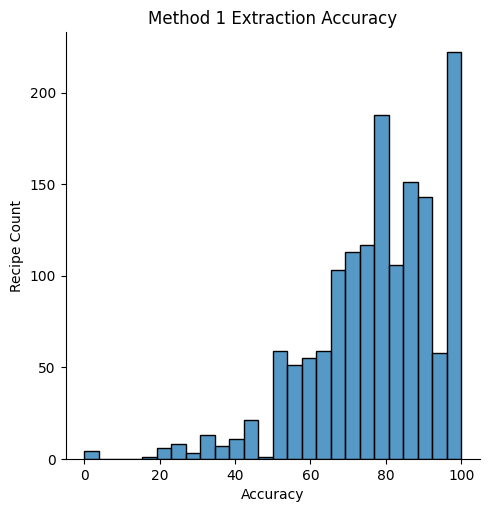

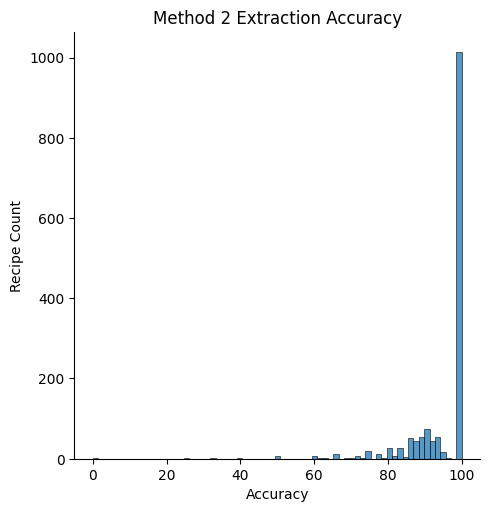

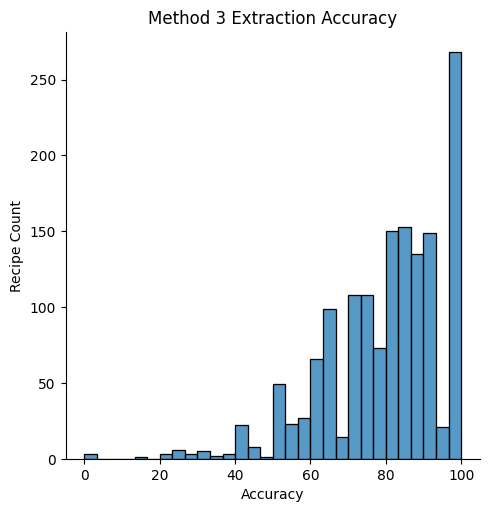

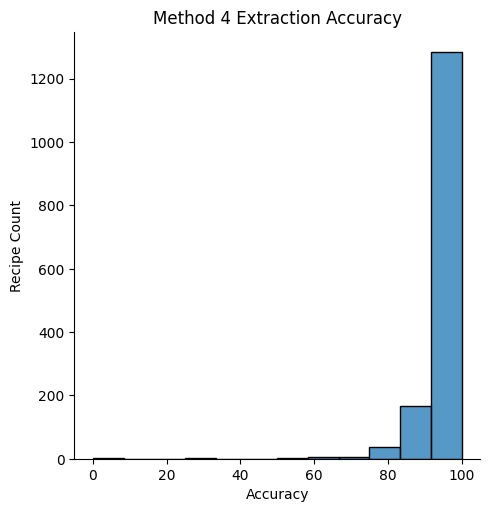

In [19]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Dictionaries to store match percentages per recipeID
match_percentage_per_recipe_m_1 = {}
match_percentage_per_recipe_m_2 = {}
match_percentage_per_recipe_m_3 = {}
match_percentage_per_recipe_m_4 = {}

# Group by `recipeID` and apply matching functions
for recipe_id, row in df.groupby('id'):
    ingredients_gt_per_id = row['ground_truth'].tolist()
    ingredients_extracted_per_id = row['extracted_ingredient'].tolist()

    # Apply match checking functions
    _, matches_per_id_1, mismatches_per_id_1 = match_checker_method_1(
        [recipe_id] * len(ingredients_gt_per_id), ingredients_gt_per_id, ingredients_extracted_per_id
    )
    _, matches_per_id_2, mismatches_per_id_2 = match_checker_method_2(
        [recipe_id] * len(ingredients_gt_per_id), ingredients_gt_per_id, ingredients_extracted_per_id
    )
    _, matches_per_id_3, mismatches_per_id_3 = match_checker_method_3(
        [recipe_id] * len(ingredients_gt_per_id), ingredients_gt_per_id, ingredients_extracted_per_id
    )
    _, matches_per_id_4, mismatches_per_id_4 = match_checker_method_4(
        [recipe_id] * len(ingredients_gt_per_id), ingredients_gt_per_id, ingredients_extracted_per_id
    )
    
    # Use match_percentage function to calculate and store match percentages
    match_percentage_per_recipe_m_1[recipe_id] = match_percentage(matches_per_id_1, mismatches_per_id_1) * 100
    match_percentage_per_recipe_m_2[recipe_id] = match_percentage(matches_per_id_2, mismatches_per_id_2) * 100
    match_percentage_per_recipe_m_3[recipe_id] = match_percentage(matches_per_id_3, mismatches_per_id_3) * 100
    match_percentage_per_recipe_m_4[recipe_id] = match_percentage(matches_per_id_4, mismatches_per_id_4) * 100

    
# Convert the results into DataFrames for easier handling
recipe_percentage_1 = pd.DataFrame(list(match_percentage_per_recipe_m_1.items()), columns=['recipeID', 'MatchPercentage'])
recipe_percentage_2 = pd.DataFrame(list(match_percentage_per_recipe_m_2.items()), columns=['recipeID', 'MatchPercentage'])
recipe_percentage_3 = pd.DataFrame(list(match_percentage_per_recipe_m_3.items()), columns=['recipeID', 'MatchPercentage'])
recipe_percentage_4 = pd.DataFrame(list(match_percentage_per_recipe_m_4.items()), columns=['recipeID', 'MatchPercentage'])

# Display results
print('Method 1:', recipe_percentage_1)
print('Method 2:', recipe_percentage_2)
print('Method 3:', recipe_percentage_3)
print('Method 4:', recipe_percentage_4)

# Calculate and display the average match percentage for each method
average_m_1 = recipe_percentage_1['MatchPercentage'].mean()
average_m_2 = recipe_percentage_2['MatchPercentage'].mean()
average_m_3 = recipe_percentage_3['MatchPercentage'].mean()
average_m_4 = recipe_percentage_4['MatchPercentage'].mean()

print(f'Average Match Percentage for Method 1: {average_m_1:.3f}%')
print(f'Average Match Percentage for Method 2: {average_m_2:.3f}%')
print(f'Average Match Percentage for Method 3: {average_m_3:.3f}%')
print(f'Average Match Percentage for Method 4: {average_m_4:.3f}%')

# Standard Deviation
print('Standard Deviation for Method 1:', recipe_percentage_1['MatchPercentage'].std())
print('Standard Deviation for Method 2:', recipe_percentage_2['MatchPercentage'].std())
print('Standard Deviation for Method 3:', recipe_percentage_3['MatchPercentage'].std())
print('Standard Deviation for Method 4:', recipe_percentage_4['MatchPercentage'].std())

# Max and Min
print('\nMax Percentage for Method 1:', recipe_percentage_1['MatchPercentage'].max())
print('Min Percentage for Method 1:', recipe_percentage_1['MatchPercentage'].min())
print('Max Percentage for Method 2:', recipe_percentage_2['MatchPercentage'].max())
print('Min Percentage for Method 2:', recipe_percentage_2['MatchPercentage'].min())
print('Max Percentage for Method 3:', recipe_percentage_3['MatchPercentage'].max())
print('Min Percentage for Method 3:', recipe_percentage_3['MatchPercentage'].min())
print('Max Percentage for Method 4:', recipe_percentage_4['MatchPercentage'].max())
print('Min Percentage for Method 4:', recipe_percentage_4['MatchPercentage'].min())




# Plot Histograms
for i, df in enumerate([recipe_percentage_1, recipe_percentage_2, recipe_percentage_3, recipe_percentage_4], start=1):
    sns.displot(data=df, x="MatchPercentage")
    plt.xlabel("Accuracy")
    plt.ylabel("Recipe Count")
    plt.title(f'Method {i} Extraction Accuracy')
    
    # plt.savefig(f"Method_{i}_extraction_accuracy.png", bbox_inches='tight')
    
    plt.show()


# statistical Functions (New Matches)

Updated Match Percentages by Recipe:       recipeID  MatchPercentage
0           39        96.153846
1          169       100.000000
2          355       100.000000
3          360       100.000000
4          503       100.000000
...        ...              ...
1495    533858        88.888889
1496    533943       100.000000
1497    534806       100.000000
1498    534857       100.000000
1499    537031       100.000000

[1500 rows x 2 columns]

Average Match Percentage: 98.17%
Standard Deviation: 5.82
Max Match Percentage: 100.00%
Min Match Percentage: 0.00%


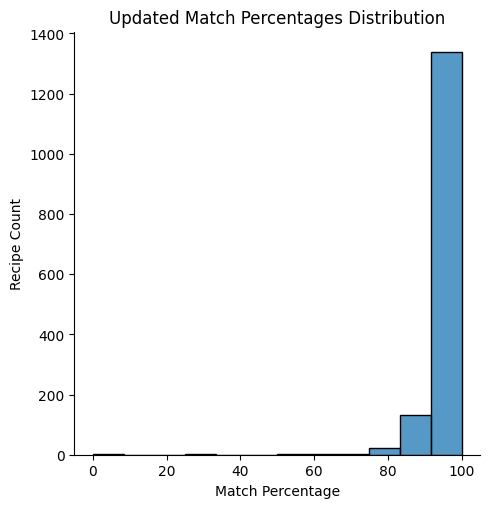

In [10]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Create DataFrames for new matches and mismatches
new_matches_df = pd.DataFrame(
    new_matches_4, columns=['id', 'ground_truth', 'extracted_ingredient']
).assign(status='Match')  # Label as matches

new_mismatches_df = pd.DataFrame(
    new_mismatches_4, columns=['id', 'ground_truth', 'extracted_ingredient']
).assign(status='Mismatch')  # Label as mismatches

# Combine the new matches and mismatches into one DataFrame
updated_df = pd.concat([new_matches_df, new_mismatches_df], ignore_index=True)

# Initialize a dictionary to store match percentages
updated_match_percentage = {}

# Group by `recipeID` and calculate match percentages
for recipe_id, group in updated_df.groupby('id'):
    matches_per_id = group[group['status'] == 'Match']
    mismatches_per_id = group[group['status'] == 'Mismatch']
    
    # Calculate match percentage
    total_count = len(matches_per_id) + len(mismatches_per_id)
    if total_count > 0:
        updated_match_percentage[recipe_id] = (len(matches_per_id) / total_count) * 100
    else:
        updated_match_percentage[recipe_id] = 0  # No matches or mismatches

# Convert the match percentages into a DataFrame
updated_recipe_percentage = pd.DataFrame(
    list(updated_match_percentage.items()), columns=['recipeID', 'MatchPercentage']
)

# Display insights for the updated matches
print('Updated Match Percentages by Recipe:', updated_recipe_percentage)

# Calculate and display overall statistics
average_match_percentage = updated_recipe_percentage['MatchPercentage'].mean()
std_match_percentage = updated_recipe_percentage['MatchPercentage'].std()
max_match_percentage = updated_recipe_percentage['MatchPercentage'].max()
min_match_percentage = updated_recipe_percentage['MatchPercentage'].min()

print(f'\nAverage Match Percentage: {average_match_percentage:.2f}%')
print(f'Standard Deviation: {std_match_percentage:.2f}')
print(f'Max Match Percentage: {max_match_percentage:.2f}%')
print(f'Min Match Percentage: {min_match_percentage:.2f}%')

# Plot a histogram for the updated match percentages
sns.displot(data=updated_recipe_percentage, x="MatchPercentage", kde=False)
plt.xlabel("Match Percentage")
plt.ylabel("Recipe Count")
plt.title("Checked Loose Percentages Distribution")
plt.show()


# Divide into bins (Old)

Frequency Distribution for Method 1:
Match Percentage Range
100%         227
80%-84%      234
85%-89%      180
90%-94%      140
95%-99%        1
Below 80%    718
Name: count, dtype: int64
Frequency Distribution for Method 2:
Match Percentage Range
100%         853
80%-84%      121
85%-89%      186
90%-94%      200
95%-99%       14
Below 80%    126
Name: count, dtype: int64
Frequency Distribution for Method 3:
Match Percentage Range
100%         274
80%-84%      238
85%-89%      196
90%-94%      153
95%-99%        2
Below 80%    637
Name: count, dtype: int64
Frequency Distribution for Method 4:
Match Percentage Range
100%         1019
80%-84%        93
85%-89%       137
90%-94%       164
95%-99%        13
Below 80%      74
Name: count, dtype: int64


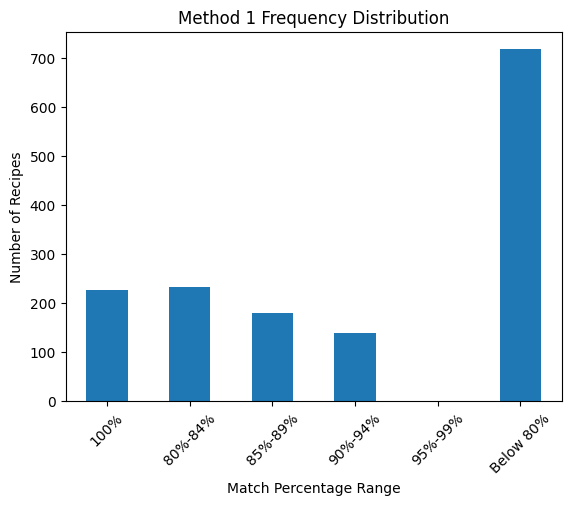

<Figure size 640x480 with 0 Axes>

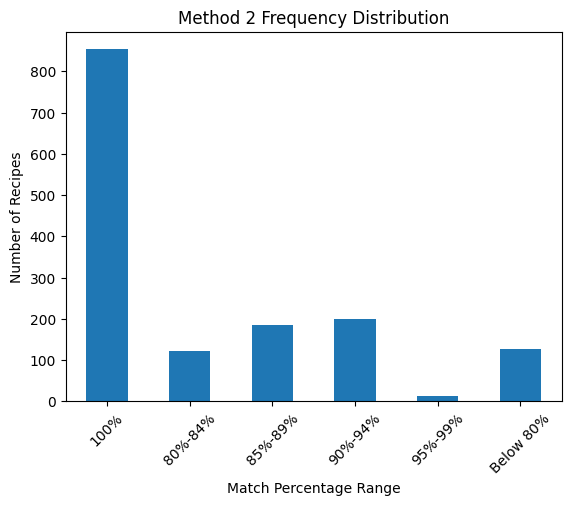

<Figure size 640x480 with 0 Axes>

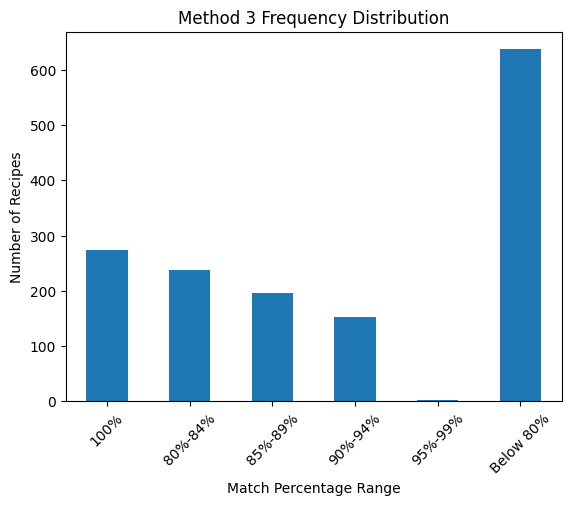

<Figure size 640x480 with 0 Axes>

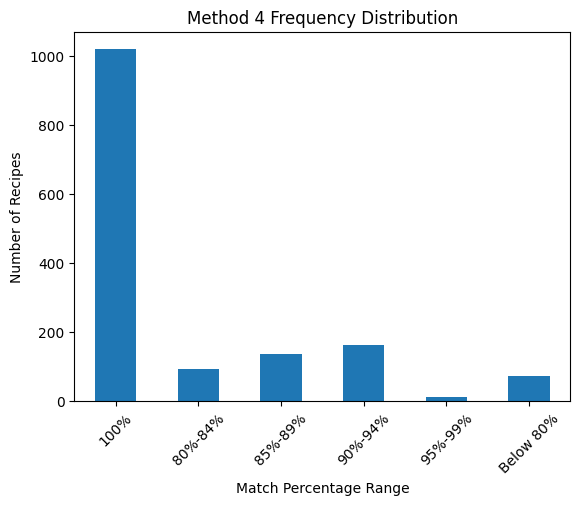

<Figure size 640x480 with 0 Axes>

In [30]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Function to categorize match percentages into bins
def categorize_into_bins(match_percentage):
    if match_percentage == 100:
        return "100%"
    elif 95 <= match_percentage < 100:
        return "95%-99%"
    elif 90 <= match_percentage < 95:
        return "90%-94%"
    elif 85 <= match_percentage < 90:
        return "85%-89%"
    elif 80 <= match_percentage < 85:
        return "80%-84%"
    else:
        return "Below 80%"

# Apply categorization for each method
bins_1 = [categorize_into_bins(m) for m in match_percentage_per_recipe_m_1.values()]
bins_2 = [categorize_into_bins(m) for m in match_percentage_per_recipe_m_2.values()]
bins_3 = [categorize_into_bins(m) for m in match_percentage_per_recipe_m_3.values()]
bins_4 = [categorize_into_bins(m) for m in match_percentage_per_recipe_m_4.values()]

# Create DataFrames to store frequency distribution
frequency_df_1 = pd.DataFrame(bins_1, columns=['Match Percentage Range'])
frequency_df_2 = pd.DataFrame(bins_2, columns=['Match Percentage Range'])
frequency_df_3 = pd.DataFrame(bins_3, columns=['Match Percentage Range'])
frequency_df_4 = pd.DataFrame(bins_4, columns=['Match Percentage Range'])

# Get the frequency distribution for each method
frequency_distribution_1 = frequency_df_1['Match Percentage Range'].value_counts().sort_index()
frequency_distribution_2 = frequency_df_2['Match Percentage Range'].value_counts().sort_index()
frequency_distribution_3 = frequency_df_3['Match Percentage Range'].value_counts().sort_index()
frequency_distribution_4 = frequency_df_4['Match Percentage Range'].value_counts().sort_index()

# Print frequency distributions
print(f'Frequency Distribution for Method 1:\n{frequency_distribution_1}')
print(f'Frequency Distribution for Method 2:\n{frequency_distribution_2}')
print(f'Frequency Distribution for Method 3:\n{frequency_distribution_3}')
print(f'Frequency Distribution for Method 4:\n{frequency_distribution_4}')

# Optionally, plot the distributions
for i, distribution in enumerate([frequency_distribution_1, frequency_distribution_2, frequency_distribution_3, frequency_distribution_4], start=1):
    distribution.plot(kind='bar', title=f'Method {i} Frequency Distribution')
    plt.xlabel("Match Percentage Range")
    plt.ylabel("Number of Recipes")
    plt.xticks(rotation=45)
    plt.show()
    plt.tight_layout()  # Adjust layout to prevent label overlap
    #Save the figure before showing it
    plt.savefig(f"Method_{i}_Frequency_Distribution_Dataset2.png", bbox_inches='tight')
    
    # Optionally, show the plot
    plt.show()
    
    # Close the plot to avoid issues with subsequent figures
    plt.close()


In [18]:
#Find out the recipes that have an average lower than 50% for string matching
print('Method 1:\n')
for recipeid, percentage in match_percentage_per_recipe_m_1.items():
    if percentage < 40:
        print('recipeID:', recipeid, 'Percentage:', percentage)
#Find out the recipes that have an average lower than 50% for string matching
print('\nExtracted within GT method:\n')
for recipeid, percentage in match_percentage_per_recipe_m_2.items():
    if percentage < 50:
        print('recipeID:', recipeid, 'Percentage:', percentage)
#Find out the recipes that have an average lower than 50% for string matching
print('\nGT within Extracted method:\n')
for recipeid, percentage in match_percentage_per_recipe_m_3.items():
    if percentage < 70:
        print('recipeID:', recipeid, 'Percentage:', percentage)
#Find out the recipes that have an average lower than 50% for string matching
print('\nWithin either column method:\n')
for recipeid, percentage in match_percentage_per_recipe_m_4.items():
    if percentage < 75:
        print('recipeID:', recipeid, 'Percentage:', percentage)
    
    

Method 1:

recipeID: 27266 Percentage: 33.33333333333333
recipeID: 44235 Percentage: 33.33333333333333
recipeID: 45546 Percentage: 36.36363636363637
recipeID: 55913 Percentage: 33.33333333333333
recipeID: 63426 Percentage: 28.57142857142857
recipeID: 83688 Percentage: 33.33333333333333
recipeID: 116672 Percentage: 33.33333333333333
recipeID: 127367 Percentage: 33.33333333333333
recipeID: 148652 Percentage: 25.0
recipeID: 150378 Percentage: 33.33333333333333
recipeID: 152122 Percentage: 33.33333333333333
recipeID: 157923 Percentage: 33.33333333333333
recipeID: 166620 Percentage: 37.5
recipeID: 171275 Percentage: 37.5
recipeID: 187394 Percentage: 28.57142857142857
recipeID: 190466 Percentage: 28.57142857142857
recipeID: 229940 Percentage: 16.666666666666664
recipeID: 232077 Percentage: 20.0
recipeID: 234607 Percentage: 33.33333333333333
recipeID: 235064 Percentage: 25.0
recipeID: 236339 Percentage: 33.33333333333333
recipeID: 274568 Percentage: 25.0
recipeID: 281529 Percentage: 36.363636

# Divide into bins (New)

Frequency Distribution for Updated Dataset:
Match Percentage Range
100%         1292
80%-84%        28
85%-89%        66
90%-94%        87
95%-99%         6
Below 80%      21
Name: count, dtype: int64


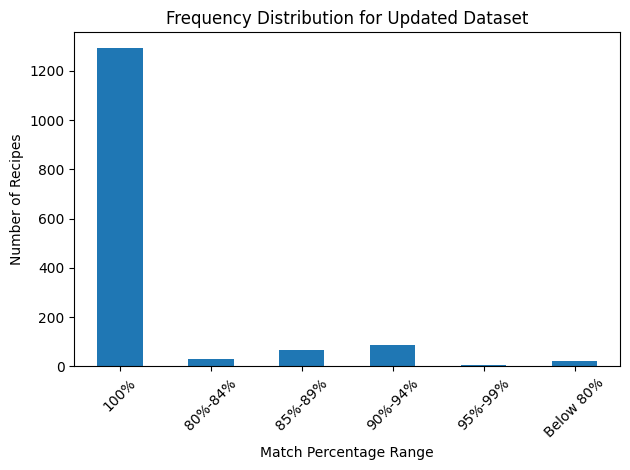

In [31]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Function to categorize match percentages into bins
def categorize_into_bins(match_percentage):
    if match_percentage == 100:
        return "100%"
    elif 95 <= match_percentage < 100:
        return "95%-99%"
    elif 90 <= match_percentage < 95:
        return "90%-94%"
    elif 85 <= match_percentage < 90:
        return "85%-89%"
    elif 80 <= match_percentage < 85:
        return "80%-84%"
    else:
        return "Below 80%"

# Apply categorization to the updated match percentages
bins_updated = [categorize_into_bins(m) for m in updated_match_percentage.values()]

# Create a DataFrame for frequency distribution
frequency_df_updated = pd.DataFrame(bins_updated, columns=['Match Percentage Range'])

# Get the frequency distribution
frequency_distribution_updated = frequency_df_updated['Match Percentage Range'].value_counts().sort_index()

# Print frequency distribution
print(f'Frequency Distribution for Updated Dataset:\n{frequency_distribution_updated}')

# Plot the distribution
frequency_distribution_updated.plot(kind='bar', title='Frequency Distribution for Updated Dataset')
plt.xlabel("Match Percentage Range")
plt.ylabel("Number of Recipes")
plt.xticks(rotation=45)
plt.tight_layout()  # Adjust layout to prevent label overlap

# Save the figure
plt.savefig("Updated_Frequency_Distribution_Dataset2.png", bbox_inches='tight')

# Show the plot
plt.show()

# Close the plot to avoid issues with subsequent figures
plt.close()
